In [1]:
import os

gpus = [2]
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf 
import tensorflow.keras as keras
import numpy as np 
#from oe_acute import MNE
import pickle
import sys
import random
#from AE import MDSAE as ae
#from network_visualisation import plot_these_aud_weights
#import network_visualisation
#import quantify_aud_strfs
import matplotlib.pyplot as plt

### Allocate GPUs

In [3]:
gpus = [2] # Here I set CUDA to only see one GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=','.join([str(i) for i in gpus])
num_gpus = len(gpus) # number of GPUs to use
if len(gpus) < 1:
    num_gpus = 1

In [4]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print( [x.name for x in local_device_protos if x.device_type == 'GPU'] )

['/device:GPU:0']


### Model function

In [5]:
class Temporal_Specgram_CNN_Model(keras.Model):
    def __init__(self, **kwargs):
        super(Temporal_Specgram_CNN_Model, self).__init__()
        self.__dict__.update(kwargs)
        self.enc_1=keras.Sequential([
            keras.Input(shape=(32, 32, 1)),
#             keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu",),
            keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation="relu",),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation = 'relu'),
        ])
        self.enc_dropout=tf.keras.layers.Dropout(0.5)
        self.dec_pred=keras.Sequential([
            tf.keras.layers.Dense(units=8 * 8 * 256, activation="relu", kernel_regularizer=keras.regularizers.L1(10**-3.5)),
            tf.keras.layers.Reshape(target_shape=(8, 8, 256)),
            tf.keras.layers.Conv2DTranspose(
                filters=8, kernel_size=2, strides=(2, 2), activation="relu", kernel_regularizer=keras.regularizers.L1(10**-3.5)
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=1, strides=(1, 1), kernel_regularizer=keras.regularizers.L1(10**-3.5)
            ),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=32, kernel_regularizer=keras.regularizers.L1(10**-3.5)),
        ])
        self.pred_losses=[]
    @tf.function
    def get_loss(self, x_t, y_t):
        #print(x_t)#.shape
        y_hat = self(tf.expand_dims(x_t, -1))
        pred_losses=tf.reduce_mean(tf.square(y_t - y_hat))             
        return pred_losses

    @tf.function
    def get_gradients(self, x_t, y_t):
        with tf.GradientTape() as tape:
            pred_losses = self.get_loss(x_t, y_t)
            #tf.print(pred_losses)
            loss=pred_losses
            
        return loss, tape.gradient(loss, self.enc_1.trainable_variables+self.dec_pred.trainable_variables)
    
    @tf.function
    def train_model(self, X_train, y_train):
        loss, gradients = self.get_gradients(X_train, y_train)
        self.optimizer.apply_gradients(zip(gradients, self.enc_1.trainable_variables+self.dec_pred.trainable_variables))
        return loss

    @tf.function
    def compute_test_loss(self, X_test, y_test):
        y_hat = self.predict(tf.expand_dims(X_test, -1))
        pred_losses=tf.reduce_mean(tf.square(y_test - y_hat))          
        return pred_losses

    def call(self, input):
        latent=self.enc_1(input)
        latent=self.enc_dropout(latent, training=True)
        return self.dec_pred(latent)

    def predict(self, input):
        latent=self.enc_1(input)
        latent=self.enc_dropout(latent, training=False)
        return self.dec_pred(latent)


### Load data

In [6]:
#def extract_spec_data(x_path, y_path, random_seed=None, global_normalize=False):
def extract_spec_data(x_path, y_path, random_seed=None):
    #all_curr=np.load(x_path,allow_pickle=True)
    #all_next=np.load(y_path,allow_pickle=True)
    all_curr = pickle.load(open(x_path, 'rb'))
    all_next = pickle.load(open(y_path, 'rb'))
    
    x_array = all_curr
    y_array = all_next

    #x_array = np.vstack(all_curr)
    #y_array = np.vstack(all_next)

    if random_seed is None:
        rand_idx=np.arange(0, np.shape(x_array)[0])
    else:
        np.random.seed(random_seed)
        rand_idx=np.random.choice(range(np.shape(x_array)[0]), size=np.shape(x_array)[0],replace=False)
    
    split_train_idx, split_val_idx = rand_idx[np.shape(x_array)[0]//10:],rand_idx[:np.shape(x_array)[0]//10] 
    x_train, x_val=np.asarray(x_array)[split_train_idx], np.asarray(x_array)[split_val_idx]
    y_train, y_val=np.asarray(y_array)[split_train_idx],np.asarray(y_array)[split_val_idx]
    
    #if global_normalize:
    #    x_train=x_train/x_train.max()
    #    y_train=y_train/y_train.max()
    #    x_val=x_val/x_val.max()
    #    y_val=y_val/y_val.max()
    return x_train,y_train,x_val,y_val

In [7]:
segs_path = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1240/segs_list_32.pkl'
next_path = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/B1240/next_list_32.pkl'

#x_train,y_train,x_val,y_val = extract_spec_data(segs_path, next_path, random_seed=0,global_normalize=True)
x_train1,y_train1,x_val1,y_val1 = extract_spec_data(segs_path, next_path, random_seed=0)

In [8]:
x_train = x_train1[:, :32, :]
x_val = x_val1[:, :32, :]
y_train = y_train1[:, :32]
y_val = y_val1[:, :32]

### Training network

Epoch 0, Train-Loss 0.019223101437091827
Epoch 1, Train-Loss 0.030225720256567
Epoch 2, Train-Loss 0.032027214765548706
Epoch 3, Train-Loss 0.03153172507882118
Epoch 4, Train-Loss 0.02479943074285984
Epoch 5, Train-Loss 0.03090149536728859
Epoch 6, Train-Loss 0.013671708293259144
Epoch 7, Train-Loss 0.0184788815677166
Epoch 8, Train-Loss 0.01307882834225893
Epoch 9, Train-Loss 0.019549250602722168
Epoch 10, Train-Loss 0.010826537385582924
Epoch 11, Train-Loss 0.015472816303372383
Epoch 12, Train-Loss 0.015219619497656822
Epoch 13, Train-Loss 0.010864516720175743
Epoch 14, Train-Loss 0.006968673784285784
Epoch 15, Train-Loss 0.015841372311115265
Epoch 16, Train-Loss 0.016574924811720848
Epoch 17, Train-Loss 0.007214629556983709
Epoch 18, Train-Loss 0.011652510613203049
Epoch 19, Train-Loss 0.010420067235827446
Epoch 20, Train-Loss 0.011538563296198845
Epoch 21, Train-Loss 0.012466239742934704
Epoch 22, Train-Loss 0.011146933771669865
Epoch 23, Train-Loss 0.012452224269509315
Epoch 24, T

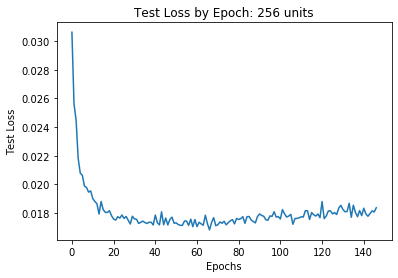

In [9]:
from collections import deque

train_dset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
train_dset = train_dset.shuffle(buffer_size=x_train.shape[0]+256).batch(64)
test_losses = []

optimizer = tf.optimizers.Adam(1e-3)
model = Temporal_Specgram_CNN_Model(optimizer=optimizer)
x_val, y_val = x_val.astype(np.float32), y_val.astype(np.float32)

early_stopping = 80

with tf.device('/device:gpu:2'):
#     tf.print('Training Fold {}'.format(index))
    #model.load_weights('./temporal_specgram_weights/initial')
    
    loss_history = deque(maxlen=early_stopping + 1)
    for epoch in range(500):
        if epoch>250:
            model.optimizer.learning_rate=2e-4
        for step, train_batch in enumerate(train_dset):
            train_loss = model.train_model(train_batch[0], train_batch[1])

        tf.print('Epoch {}, Train-Loss {}'.format(epoch, train_loss), output_stream=sys.stdout)
        test_losses.append(model.compute_test_loss(x_val, y_val))
        
        loss_history.append((model.compute_test_loss(x_val, y_val)).numpy())

        if len(loss_history) > early_stopping:
            if loss_history.popleft() < min(loss_history):
                print(f'\nEarly stopping. No validation loss '
                      f'improvement in {early_stopping} epochs.')
                break
        
    plt.plot(test_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')
    plt.title('Test Loss by Epoch: {} units'.format(256))
    #plt.savefig('mnt/cube/srrudrar/temporal_model/loss_plots/{}units_loss.png'.format(256))

In [10]:
with tf.device('/device:gpu:2'):
    #model.save_weights('/mnt/cube/srrudrar/temporal_model/temporal_model_weights/temp_256_l1_3_5_500epoch_64batch.h5')
    #predicted = model.full_model(x_val)
    enc_train1 = model.enc_dropout(model.enc_1(x_train[:15000,:,:][:,:,:,np.newaxis]))
    enc_train2 = model.enc_dropout(model.enc_1(x_train[15000:30000,:,:][:,:,:,np.newaxis]))
    enc_train3 = model.enc_dropout(model.enc_1(x_train[30000:45000,:,:][:,:,:,np.newaxis]))
    enc_train4 = model.enc_dropout(model.enc_1(x_train[45000:,:,:][:,:,:,np.newaxis]))
    enc_val = model.enc_dropout(model.enc_1(x_val[:,:,:,np.newaxis]))
    #tf.print(predicted.shape)
    tf.print(enc_train1.shape)
    tf.print(enc_train2.shape)
    tf.print(enc_train3.shape)
    tf.print(enc_val.shape)

TensorShape([15000, 256])
TensorShape([15000, 256])
TensorShape([15000, 256])
TensorShape([5706, 256])


In [11]:
with tf.device('/device:gpu:2'):
    #model.save_weights('/mnt/cube/srrudrar/temporal_model/temporal_model_weights/temp_256_l1_3_5_500epoch_64batch.h5')
    #predicted = model.full_model(x_val)
    dec_val = model.dec_pred(model.enc_dropout(model.enc_1(x_val[:,:,:,np.newaxis])))
    #tf.print(predicted.shape)
    tf.print(dec_val.shape)

TensorShape([5706, 32])


In [12]:
enc_train = np.vstack([enc_train1, enc_train2, enc_train3, enc_train4])
enc_val = np.vstack([enc_val])

enc_train_reshape = np.reshape(enc_train, (len(enc_train),16,16))

In [13]:
np.shape(enc_train), np.shape(x_train), np.shape(enc_val), np.shape(x_val)

((51357, 256), (51357, 32, 32), (5706, 256), (5706, 32, 32))

Text(0.5, 1.05, 'Mel Spectrogram')

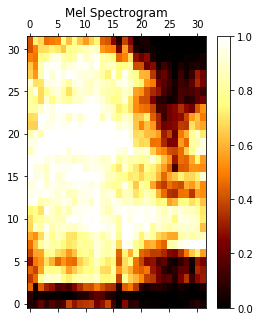

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(4,5))
cax = ax.matshow(x_train[100], interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Mel Spectrogram')

Text(0.5, 1.05, 'Mel Spectrogram')

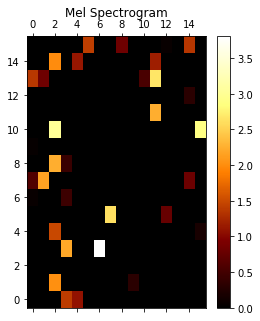

In [15]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(4,5))
cax = ax.matshow(enc_train_reshape[100], interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Mel Spectrogram')

In [16]:
resp_train = x_train1[:, 32:, :]
spec_train = [x.flatten() for x in x_train]
#enc_train

resp_test = x_val1[:, 32:, :]
spec_test = [x.flatten() for x in x_val]
#enc_test = enc_val
#x_val = x_val[:, :16, :]
#y_train = y_train[:, :16]
#y_val = y_val[:, :16]

In [17]:
np.shape(spec_train), np.shape(enc_train), np.shape(resp_train), np.shape(spec_test), np.shape(enc_val), np.shape(resp_test)

((51357, 1024),
 (51357, 256),
 (51357, 214, 32),
 (5706, 1024),
 (5706, 256),
 (5706, 214, 32))

In [18]:
d = 256
np.save('/mnt/cube/srrudrar/tcm3/B1240/32x32/stim_resp_32x32_{}/spec_train_{}.npy'.format(d,d), spec_train)
np.save('/mnt/cube/srrudrar/tcm3/B1240/32x32/stim_resp_32x32_{}/enc_train_{}.npy'.format(d,d), enc_train)
np.save('/mnt/cube/srrudrar/tcm3/B1240/32x32/stim_resp_32x32_{}/resp_train_{}.npy'.format(d,d), resp_train)

np.save('/mnt/cube/srrudrar/tcm3/B1240/32x32/stim_resp_32x32_{}/spec_test_{}.npy'.format(d,d), spec_test)
np.save('/mnt/cube/srrudrar/tcm3/B1240/32x32/stim_resp_32x32_{}/enc_test_{}.npy'.format(d,d), enc_val)
np.save('/mnt/cube/srrudrar/tcm3/B1240/32x32/stim_resp_32x32_{}/resp_test_{}.npy'.format(d,d), resp_test)

In [19]:
np.save('/mnt/cube/srrudrar/tcm3/B1240/32x32/stim_resp_32x32_{}/y_train_{}.npy'.format(d,d), y_train)
np.save('/mnt/cube/srrudrar/tcm3/B1240/32x32/stim_resp_32x32_{}/y_test_{}.npy'.format(d,d), y_val)